# Comparison of two multinomial observations

In [1]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

In [2]:
total_samples = 639
pre_debate = [294, 307, 38]  # bush, dukakis, other
post_debate = [288, 332, 19]

In [3]:
coords = {"candidates": ["Bush", "Dukakis", "Others"], "debate": ["pre", "post"]}

with pm.Model(coords=coords) as m:
    alphas = pm.Uniform("alpha", lower=0, upper=10, dims=("debate", "candidates"))
    proportions = pm.Dirichlet("proportions", a=alphas, dims=("debate", "candidates"))
    diff = pm.Deterministic(
        "diff",
        proportions[1][0] / (proportions[1][0] + proportions[1][1])
        - proportions[0][0] / (proportions[0][0] + proportions[0][1]),
    )

    votes = pm.Multinomial(
        "votes",
        n=total_samples,
        p=proportions,
        observed=[pre_debate, post_debate],
        dims=("debate", "candidates"),
    )

    trace = pm.sample(2000, tune=1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, proportions]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


In [4]:
az.summary(trace, var_names=["proportions", "diff"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"proportions[pre, Bush]",0.460,0.020,0.423,0.498,0.0,0.0,12500.0,5861.0,1.0
"proportions[pre, Dukakis]",0.479,0.020,0.443,0.517,0.0,0.0,12762.0,5724.0,1.0
"proportions[pre, Others]",0.061,0.010,0.043,0.079,0.0,0.0,10499.0,5798.0,1.0
"proportions[post, Bush]",0.450,0.020,0.415,0.489,0.0,0.0,10057.0,6493.0,1.0
"proportions[post, Dukakis]",0.519,0.020,0.480,0.554,0.0,0.0,9893.0,6461.0,1.0
"proportions[post, Others]",0.031,0.007,0.019,0.044,0.0,0.0,10730.0,5705.0,1.0
diff,-0.025,0.028,-0.078,0.027,0.0,0.0,11032.0,7053.0,1.0


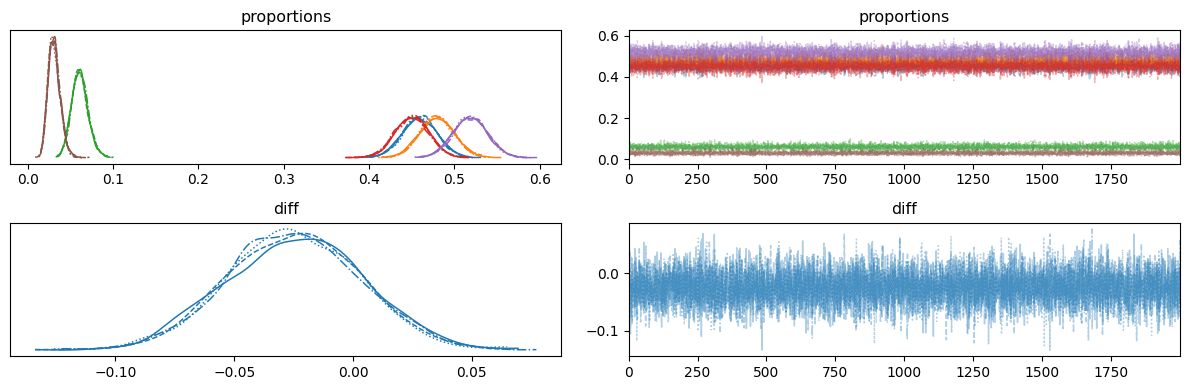

In [5]:
az.plot_trace(trace, var_names=["proportions", "diff"])
plt.tight_layout()
plt.show()

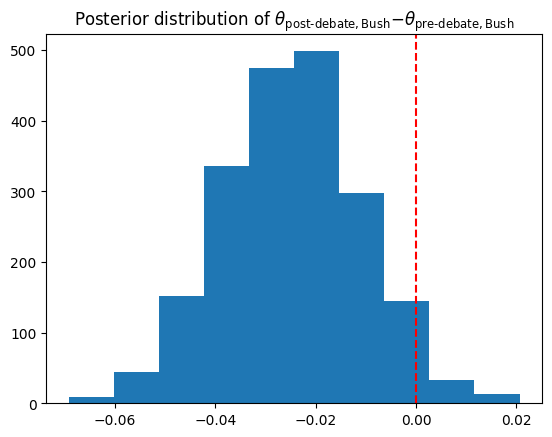

In [6]:
plt.hist(trace.posterior["diff"].mean("chain"))

plt.axvline(0, linestyle="--", color="red")
plt.title(
    r"Posterior distribution of $\theta_{\text{post-debate}, \text{Bush}}$"
    r"$- \theta_{\text{pre-debate},\text{Bush}}$"
)
plt.show()

Question: What is the posterior probability that there was a shift towards Bush?

We need to calculate $P \left(\theta_{\text{post},\text{Bush}} - \theta_{\text{post},\text{Bush}} > 0\right)$. Therefore, we calculate the proportion of samples in the posterior distribution of the `diff` variable in the above model that are greater than 0:

In [7]:
(trace.posterior["diff"].mean("chain") > 0).mean().values.tolist()

0.039